## 1. Load the Data

In [1]:
import pandas as pd

In [2]:
df_engagement = pd.read_csv('./takehome_user_engagement.csv')
df = pd.read_csv('./takehome_users.csv')

In [3]:
df_engagement.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


In [4]:
df_engagement['visited'].unique()

array([1])

## 2. Define and Label the Adopted User

### Convert the time_stamp from string to datetime

In [5]:
from datetime import datetime 
def str2time(s): 
    return datetime.strptime(s, "%Y-%m-%d %H:%M:%S")

In [6]:
df_engagement['time_stamp'] = df_engagement['time_stamp'].apply(str2time)

### Group the table takehome_user_engagement by user_id and apply list to the time_stamp columns

In [7]:
df_engagement_by_user = df_engagement.groupby('user_id', as_index=False).agg({'time_stamp':lambda x: x.tolist()})

In [8]:
df_engagement_by_user.head(3)

,user_id,time_stamp
0,1,[2014-04-22 03:53:30]
1,2,"[2013-11-15 03:45:04, 2013-11-29 03:45:04, 201..."
2,3,[2013-03-19 23:14:52]


In [9]:
print df.shape, df_engagement.shape, df_engagement_by_user.shape

(12000, 10) (207917, 3) (8823, 2)


In [10]:
len(df_engagement['user_id'].unique())

8823

### Based on the definition of an adopted user, the time stamp list should have at least three items and three separate days in at least one seven-day. Insert a feature called ‘adopted_user’ in the takehome_user_engagement table: value 1 means that the user is an adopted user; value 0 means that the user is for not adopted user. 

In [11]:
def check_if_adopted_user(datelist):
    if len(datelist) < 3:
        return 0
    time_diff = [i.day - min(datelist).day for i in datelist]
    time_diff = list(set(time_diff))
    time_diff.sort()
    if len(time_diff) < 3:
        return 0
    for i in range(len(time_diff) -2):
        first = time_diff[i]
        second = time_diff[i+1]
        third = time_diff[i+2]
        if third - first < 7:
            return 1
        else:
            continue
    return 0

In [12]:
df_engagement_by_user['adopted_user']= df_engagement_by_user['time_stamp'].apply(check_if_adopted_user)

In [13]:
df_engagement_by_user.head(3)

,user_id,time_stamp,adopted_user
0,1,[2014-04-22 03:53:30],0
1,2,"[2013-11-15 03:45:04, 2013-11-29 03:45:04, 201...",1
2,3,[2013-03-19 23:14:52],0


In [14]:
df_engagement_by_user.drop(['time_stamp'],axis=1,inplace=True)

In [15]:
df['creation_time'] = df['creation_time'].apply(str2time)
df['last_session_creation_time'] = df['last_session_creation_time'].apply(lambda x: datetime.utcfromtimestamp(x) if x== x else x)

### Join the takehome_users table on user_id with the engagement table takehome_user_engagement on object_idwith the takehome_users table.

In [16]:
df_f = df_engagement_by_user.merge(df, left_on='user_id', right_on='object_id', how='outer')

In [17]:
df_f.head(3)

,user_id,adopted_user,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1.0,0.0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2.0,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3.0,0.0,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0


In [18]:
df_f.shape

(12000, 12)

### Fill none values in 'adopted_user' column

In [19]:
df_f['adopted_user'].unique()

array([  0.,   1.,  nan])

In [20]:
df_f['adopted_user'] = df_f['adopted_user'].apply(lambda x: 0 if x != x else x)

In [21]:
df_f['adopted_user'].unique()

array([ 0.,  1.])

## 3. Exploratary Data Analysis

In [22]:
from collections import Counter
Counter(df_f['adopted_user'])

Counter({0.0: 10240, 1.0: 1760})

In [23]:
df_f['if_invited'] = df_f['invited_by_user_id'].apply(lambda x: 1 if x == x else 0)

### Generate this new feature by extracting the domain of the email

In [24]:
df_f['email_domain'] = df_f['email'].apply(lambda x: x.split('@')[1].split('.')[0])

In [25]:
Counter(df_f['email_domain']).most_common(20)

[('gmail', 3562),
 ('yahoo', 2447),
 ('jourrapide', 1259),
 ('cuvox', 1202),
 ('gustr', 1179),
 ('hotmail', 1165),
 ('luque', 2),
 ('qgjbc', 2),
 ('dqwln', 2),
 ('rerwl', 2),
 ('oqpze', 2),
 ('xvnbr', 2),
 ('xybhi', 2),
 ('mumdc', 2),
 ('rqbhi', 1),
 ('ilhbl', 1),
 ('qotem', 1),
 ('uhbku', 1),
 ('cyqff', 1),
 ('pfgnw', 1)]

### Only pick the top 7 domain based on the frequency, and tag all the rest as ‘others’.

In [26]:
df_f['email_domain']=df_f['email_domain'].apply(lambda x: x if x in ['gmail', 'yahoo','jourrapide','cuvox', 'gustr', 'hotmail'] else 'others' )

### Create ‘if_invited_adopted’ feature based on feature ‘adopted_user’ and ‘invited_by_user_id’. There are three values in this feature. 1: invited by an adopted user; 0: invited by a user who is not an adopted user; -1: not invited by any user.

In [27]:
df_f['adopted_user']=df_f['adopted_user'].apply(int)

In [28]:
adopted_user_id = df_f[df_f['adopted_user']==1]['user_id'].tolist()
df_f['if_invited_adpoted'] = df_f['invited_by_user_id'].apply(lambda x: -1 if x != x else 1 if x in adopted_user_id else 0)

In [29]:
len(df_f['org_id'].unique())
org_count = Counter(df_f['org_id'].tolist())
org_count.most_common(20)

[(0, 319),
 (1, 233),
 (2, 201),
 (3, 168),
 (4, 159),
 (6, 138),
 (5, 128),
 (9, 124),
 (7, 119),
 (10, 104),
 (8, 97),
 (14, 87),
 (11, 75),
 (12, 75),
 (17, 74),
 (18, 73),
 (13, 72),
 (16, 72),
 (20, 68),
 (15, 64)]

### Drop irrelavent features

In [30]:
df_f.drop(['object_id','name', 'creation_time','email','last_session_creation_time','invited_by_user_id'],axis=1,inplace=True)

In [31]:
df_f.head(3)

,user_id,adopted_user,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,if_invited,email_domain,if_invited_adpoted
0,1.0,0,GUEST_INVITE,1,0,11,1,yahoo,0
1,2.0,1,ORG_INVITE,0,0,1,1,gustr,0
2,3.0,0,ORG_INVITE,0,0,94,1,gustr,1


### Define functions check_ratio and check_cnt to figure out the distribution of each feature for if_invited_adopted column

In [32]:
def check_ratio(df, s):
    check = df[s].unique().tolist()
    result = {}
    for i in check:
        tmp = dict(Counter(df[df[s]==i]['adopted_user']))
        result[i] = tmp[1]*1.0/(tmp[0]+tmp[1])
    return sorted(result.items(), key=lambda x: x[1], reverse=True)

In [33]:
def check_cnt(df, s):
    check = df[s].unique().tolist()
    result = {}
    for i in check:
        result[i] = dict(Counter(df[df[s]==i]['adopted_user'])).items()
    return result

In [34]:
check_ratio(df_f, 'creation_source')

[('SIGNUP_GOOGLE_AUTH', 0.18411552346570398),
 ('GUEST_INVITE', 0.1821544151641239),
 ('SIGNUP', 0.1509343555342597),
 ('ORG_INVITE', 0.14456981664315938),
 ('PERSONAL_PROJECTS', 0.08574135480814779)]

In [35]:
print check_ratio(df_f, 'if_invited_adpoted'), check_cnt(df_f, 'if_invited_adpoted')

[(1, 0.21724137931034482), (0, 0.14399847821951683), (-1, 0.13451549346229624)] {0: [(0, 4500), (1, 757)], 1: [(0, 908), (1, 252)], -1: [(0, 4832), (1, 751)]}


In [36]:
c = check_ratio(df_f, 'creation_source')
c

[('SIGNUP_GOOGLE_AUTH', 0.18411552346570398),
 ('GUEST_INVITE', 0.1821544151641239),
 ('SIGNUP', 0.1509343555342597),
 ('ORG_INVITE', 0.14456981664315938),
 ('PERSONAL_PROJECTS', 0.08574135480814779)]

In [37]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

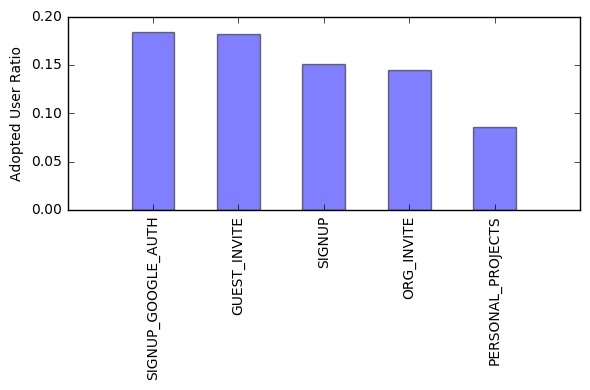

In [38]:
x = zip(*c)[0]
y = zip(*c)[1]
x_pos = np.arange(len(x)) 
  
plt.bar(x_pos, y ,align='center',color = 'blue',alpha = 0.5, width = 0.5)
plt.xticks(x_pos, x, rotation='vertical') 
plt.ylabel('Adopted User Ratio')
plt.tight_layout()
plt.savefig('creation_source.png')

In [39]:
o = check_ratio(df_f, 'opted_in_to_mailing_list')
o

[(1, 0.1492985971943888), (0, 0.14579169442593826)]

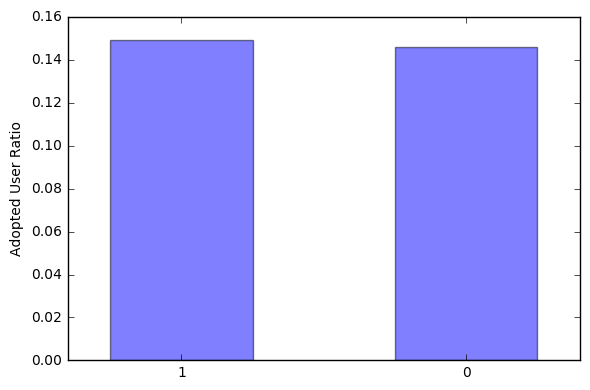

In [40]:
x = zip(*o)[0]
y = zip(*o)[1]
x_pos = np.arange(len(x)) 
  
plt.bar(x_pos, y ,align='center',color = 'blue',alpha = 0.5, width = 0.5)
plt.xticks(x_pos, x) 
plt.ylabel('Adopted User Ratio')
plt.tight_layout()

In [41]:
e = check_ratio(df_f, 'enabled_for_marketing_drip')
e

[(1, 0.15234375), (0, 0.14567006269592475)]

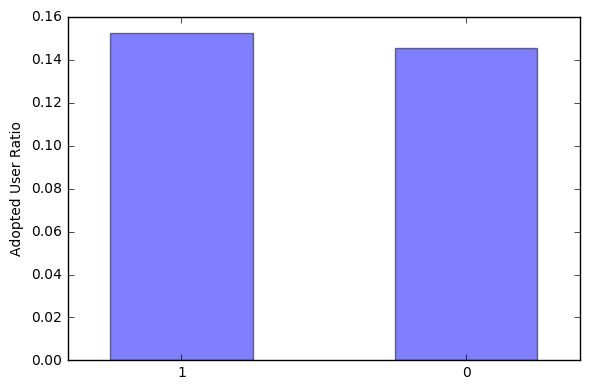

In [42]:
x = zip(*e)[0]
y = zip(*e)[1]
x_pos = np.arange(len(x)) 
  
plt.bar(x_pos, y ,align='center',color = 'blue',alpha = 0.5, width = 0.5)
plt.xticks(x_pos, x) 
plt.ylabel('Adopted User Ratio')
plt.tight_layout()

In [43]:
d = check_ratio(df_f, 'email_domain')
d

[('hotmail', 0.18283261802575107),
 ('gmail', 0.1664795058955643),
 ('others', 0.15008431703204048),
 ('jourrapide', 0.13899920571882446),
 ('gustr', 0.13401187446988974),
 ('cuvox', 0.1264559068219634),
 ('yahoo', 0.11892112791172865)]

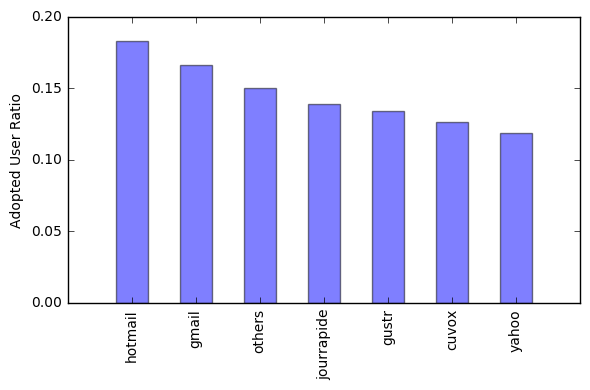

In [44]:
x = zip(*d)[0]
y = zip(*d)[1]
x_pos = np.arange(len(x)) 
  
plt.bar(x_pos, y ,align='center',color = 'blue',alpha = 0.5, width = 0.5)
plt.xticks(x_pos, x, rotation='vertical') 
plt.ylabel('Adopted User Ratio')
plt.tight_layout()
plt.savefig('email_domain.png')

In [45]:
i = check_ratio(df_f, 'if_invited_adpoted')
i

[(1, 0.21724137931034482), (0, 0.14399847821951683), (-1, 0.13451549346229624)]

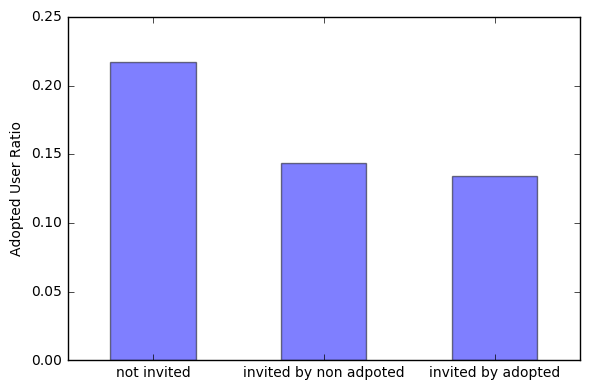

In [46]:
x = ['not invited','invited by non adpoted','invited by adopted']
y = zip(*i)[1]
x_pos = np.arange(len(x)) 

plt.bar(x_pos, y ,align='center',color = 'blue',alpha = 0.5, width = 0.5)
plt.xticks(x_pos, x) 
plt.ylabel('Adopted User Ratio')
plt.tight_layout()
plt.savefig('invited.png')

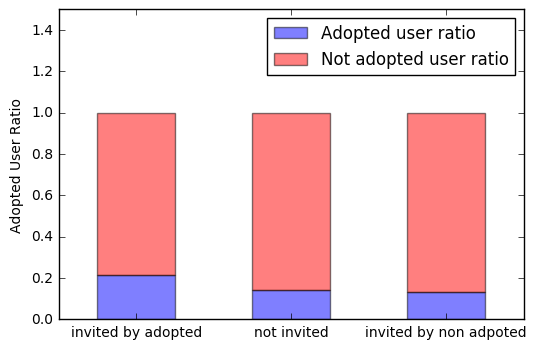

In [47]:
x = ['invited by adopted','not invited','invited by non adpoted']
y1 = zip(*i)[1]
y2 = [1 - y for y in y1]
x_pos = np.arange(len(x)) 

p1 = plt.bar(x_pos, y1, align = 'center', color = 'blue',alpha = 0.5, width = 0.5)
p2 = plt.bar(x_pos, y2, bottom=y1,align = 'center',  color = 'red',alpha = 0.5, width = 0.5)
plt.xticks(x_pos, x) 
plt.ylabel('Adopted User Ratio')
plt.legend((p1[0], p2[0]), ('Adopted user ratio', 'Not adopted user ratio'))
plt.ylim((0,1.5))
plt.savefig('invited2.png')

## 4. Machine Learning (Classification)

In [48]:
df_f.head(3)

,user_id,adopted_user,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,if_invited,email_domain,if_invited_adpoted
0,1.0,0,GUEST_INVITE,1,0,11,1,yahoo,0
1,2.0,1,ORG_INVITE,0,0,1,1,gustr,0
2,3.0,0,ORG_INVITE,0,0,94,1,gustr,1


In [49]:
df_f.drop(['user_id'], axis = 1, inplace = True)

### Use one hot encoding to convert each value in categorical data to dummy features

In [50]:
X = df_f.drop(['adopted_user'],axis=1)
y = df_f['adopted_user']
X_f = pd.get_dummies(X, columns=['creation_source','org_id','email_domain','if_invited_adpoted'])

In [51]:
X_f.shape

(12000, 435)

In [52]:
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split,StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix,roc_curve, auc,roc_auc_score, accuracy_score
from sklearn.metrics import (precision_score, recall_score, f1_score)
from sklearn.metrics import (precision_score, recall_score, f1_score)
from sklearn.metrics import classification_report
import math

### Split training and testing data

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_f, y, test_size=0.25, stratify=y, random_state=0)   

### Use 5-fold cross validation in grid search to find the optimal the hyper parameteparameter, C

In [54]:
clf_g_l1 = GridSearchCV(
    estimator = LogisticRegression(class_weight='balanced', 
                                   penalty='l1',
                                   random_state=0,
                                   n_jobs=-1), 
    param_grid = {'C': [0.01,0.025, 0.05,0.075, 0.1, 0.25, 0.5,0.75, 1]},
    scoring='recall', 
    cv=5,
    n_jobs = -1)
clf_g_l1.fit(X_train, y_train)
    
print "Best estimator found by grid search:"
print clf_g_l1.best_estimator_

Best estimator found by grid search:
LogisticRegression(C=0.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [55]:
def print_grid_score(clf_g_l1):
    score_result = clf_g_l1.grid_scores_
    for i in sorted(score_result, key=lambda x: x[1],reverse=True):
        print i

In [56]:
print_grid_score(clf_g_l1)

mean: 0.61591, std: 0.03255, params: {'C': 0.25}
mean: 0.60379, std: 0.04263, params: {'C': 0.05}
mean: 0.59697, std: 0.02069, params: {'C': 0.025}
mean: 0.59545, std: 0.03532, params: {'C': 0.1}
mean: 0.59394, std: 0.03508, params: {'C': 0.075}
mean: 0.56212, std: 0.03823, params: {'C': 0.5}
mean: 0.53864, std: 0.03408, params: {'C': 0.75}
mean: 0.52273, std: 0.02646, params: {'C': 1}
mean: 0.16970, std: 0.13342, params: {'C': 0.01}


### Validate the performance of logistic regression model

In [57]:
def model_eval(clf, X_train, y_train, X_test, y_test):
    try:
        y_train_pred = clf.predict(X_train)
        y_train_prob = [i[1] for i in clf.predict_proba(X_train)]
    
        y_test_pred = clf.predict(X_test)
        y_test_prob = [i[1] for i in clf.predict_proba(X_test)]
    except:
        y_train_prob = clf.predict(X_train)
        y_train_pred = [1 if i >=0.5 else 0 for i in y_train_prob]
        y_test_prob = clf.predict(X_test)
        y_test_pred = [1 if i >=0.5 else 0 for i in y_test_prob]
        
    
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    print('Training Result: ')
    print('Precison: %.3f' % precision_score(y_train, y_train_pred))
    print('Recall: %.3f' % recall_score(y_train, y_train_pred))
    print('F1: %.3f' % f1_score(y_train, y_train_pred))
    print('ROC AUC: %.3f' % roc_auc_score(y_train, y_train_prob))
    labels = [0, 1]
    confmat = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
    print(confmat)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.grid('off',which='major')
    plt.show()
    
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    print('Test Result: ')    
    print('Precison: %.3f' % precision_score(y_test, y_test_pred))
    print('Recall: %.3f' % recall_score(y_test, y_test_pred))
    print('F1: %.3f' % f1_score(y_test, y_test_pred))
    print('ROC AUC: %.3f' % roc_auc_score(y_test, y_test_prob))
    
    labels = [0, 1]
    confmat = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    print(confmat)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.grid('off',which='major')
    plt.show()

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Result: 
Precison: 0.174
Recall: 0.611
F1: 0.271
ROC AUC: 0.606
[[3854, 3826], [514, 806]]


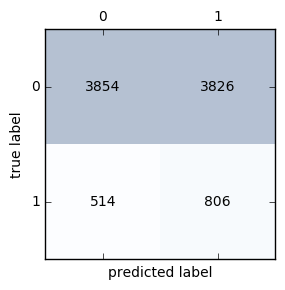

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Test Result: 
Precison: 0.172
Recall: 0.607
F1: 0.269
ROC AUC: 0.601
[[3824, 3856], [519, 801]]


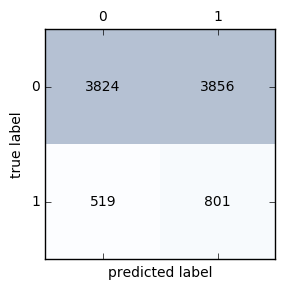

In [59]:
model_eval(clf_g_l1, X_train, y_train, X_test, y_test)

## 5. Feature Importance 

In [59]:
def plot_top30_positive(clf, X):
    feat_labels = X.columns.values.tolist()
    feat_labels = [unicode(s, "utf-8") for s in feat_labels]
    try:
        coef_result = zip(feat_labels, clf.coef_[0])
    except:
        coef_result = zip(feat_labels, clf.feature_importances_)
    coef_result = sorted(coef_result, key=lambda x: x[1], reverse=True)[:30]
    fig = plt.figure()
    ax = plt.subplot(111)
    width=0.8
    ax.bar(range(len(coef_result)), [x[1] for x in coef_result], alpha = 0.5,width=width)
    ax.set_xticks(np.arange(len(coef_result)) + width/2)
    ax.set_xticklabels([x[0] for x in coef_result], rotation=90)
    plt.title("Top 30 Important Feature Coefficients for Adopted User")
    plt.savefig('feature_importance.png')

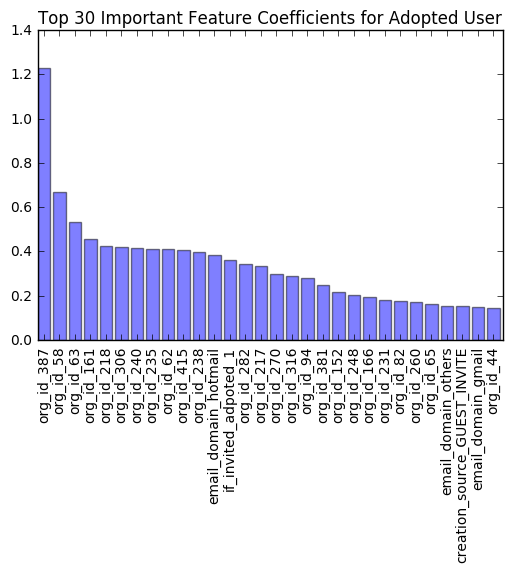

In [60]:
plot_top30_positive(clf_g_l1.best_estimator_, X_f)

In [61]:
def plot_top30_important(clf, X):
    feat_labels = X.columns.values.tolist()
    feat_labels = [unicode(s, "utf-8") for s in feat_labels]
    try:
        coef_result = zip(feat_labels, clf.coef_[0])
    except:
        coef_result = zip(feat_labels, clf.feature_importances_)
    coef_result = sorted(coef_result, key=lambda x: abs(x[1]), reverse=True)[:30]
    fig = plt.figure()
    ax = plt.subplot(111)
    width=0.8
    ax.bar(range(len(coef_result)), [x[1] for x in coef_result], alpha = 0.5,width=width)
    ax.set_xticks(np.arange(len(coef_result)) + width/2)
    ax.set_xticklabels([x[0] for x in coef_result], rotation=90)
    plt.title("Top 30 Important Feature coefficients")
    plt.savefig('feature_importance2.png')

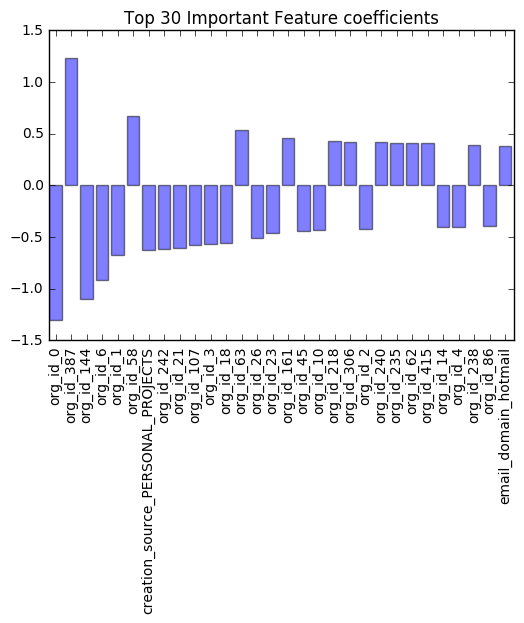

In [62]:
plot_top30_important(clf_g_l1.best_estimator_, X_f)

### Figure 'Top 30 Important Feature Coefficients for Adopted User' should be more useful here, since these features have positive effect in predicting adopted user